In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
             # 'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in",
              'legend.fontsize': 20}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x',length=10,direction='out')
    ax.tick_params(axis='x',which='minor',direction='out')
    ax.tick_params(axis='y',length=10,direction='out')
    ax.tick_params(axis='y',which='minor',direction='out')

In [4]:
import pickle
import itertools
import math
import random
import pandas as pd
import numpy as np
import networkx as nx

from datetime import date

In [5]:
df_removal = pd.read_pickle('../results/us_air_data_binary_removal.pkl').replace([np.inf, -np.inf], np.nan).dropna(how='all')
df_removal = df_removal[df_removal.year>=date(2004,1,1)]
rename_dict = {}
for column in df_removal.columns:
    if '_index' in column:
        column_v = column.replace('_index','',1)
    else:
        column_v =  column
    rename_dict[column]=column_v.replace('_',' ',3).title()
    
rename_again = {'Common Neighbor' : 'CN', 'Salton':'SA' , 'Jaccard':'JA', 'Sorensen':'SO', 'Hub Promoted':'HPI',
       'Hub Depressed':'HDI', 'Leicht Holme Newman':'LHNI', 'Preferential Attachment':'PA',
       'Adamic Adar':'AA', 'Resource Allocation':'RA', 'Local Path':'LP'}
    
df_removal = df_removal.rename(columns=rename_dict).rename(columns={'Prederential Attachment':'Preferential Attachment'})

columns=['Common Neighbor', 'Salton', 'Jaccard', 'Sorensen', 'Hub Promoted',
       'Hub Depressed', 'Leicht Holme Newman', 'Preferential Attachment',
       'Adamic Adar', 'Resource Allocation', 'Local Path',
        'Year','Edge','Time','Label']

df_removal =  df_removal[columns]#.rename(columns=rename_again)

In [6]:
df_add = pd.read_pickle('../results/us_air_data_binary_adding.pkl')
df_add = df_add[df_add.Year>=date(2004,1,1)]

In [7]:
df_air = pd.read_pickle('../data/networks/US_air_1990_2018.pkl')
nodes = set(df_air.source.unique())|set(df_air.target.unique())
df_air = df_air[df_air.source != df_air.target]
year = list(df_air.index.get_level_values(0).unique())
month = list(df_air.index.get_level_values(1).unique())
graphs_air = []
date_air = []
for y in year:
    for m in month:
#        if y != 2018 or m != 12:
        df = df_air.loc[y,m]
        date_air.append(date(y,m,1))
        G = nx.from_pandas_edgelist(df_air.loc[y,m], edge_attr=True)
        G.add_nodes_from(nodes)
        graphs_air.append(G)
        

n = date_air.index(date(2004,1,1))
graphs_air = graphs_air[n:]
date_air =  date_air[n:]

del df_air

In [8]:
def get_edge_slice(data,f_train_e=0.7,seed=30):
    df = data
    edges = list(df.Edge.unique())
    random.seed(seed)
    edge_train = random.sample(edges,int(f_train_e*len(edges)))
    edge_test = [e for e in edges if e not in edge_train]
    df_se = df.loc[df['Edge'].isin(edge_train)].drop(columns = ['Edge','Time'])
    df_de = df.loc[df['Edge'].isin(edge_test)].drop(columns = ['Edge','Time'])
    return(df_se,df_de)

def get_time_slice(data,time_start,time_end,droptime=True):
    if droptime:
        return(data[data.Year >= time_start][data.Year <= time_end].drop(columns = ['Year']))
    else:
        return(data[data.Year >= time_start][data.Year <= time_end])
    
def df_to_XY(df):
    if 'Year' in df.columns: 
        df = df.drop(columns = ['Year'])
        if "Edge" in df.columns:
            df = df.drop(columns = ['Edge'])
    X,y = df.loc[:, df.columns != 'Label'].to_numpy(),\
    df.loc[:, df.columns == 'Label'].to_numpy()
    return(X,y)

In [9]:
def local_path(G,nodelist,epsilon = 0.01):
    A = nx.adjacency_matrix(G,weight=None).todense()
    return(A**2+epsilon*A**3)

def my_devide(a,b):
    if a!=0 and b!=0:
        return a/b
    else:
        return 0
    
def get_vector(G,edges):
    X,y = [],[]
    Ki = G.degree()
    nodelist = list(G.nodes())
    LPI = local_path(G,nodelist)
    NBs = dict([(u,set(G[u])) for u in G.nodes()])
    for e in edges:
        u,v = e
        union_size = len(NBs[u]|NBs[v])
        x = []
        uv_intersection = list(nx.common_neighbors(G,u,v))
        x.append(len(uv_intersection))
        x.append(my_devide(len(uv_intersection),np.sqrt(Ki[u]*Ki[v])))
        x.append(my_devide(len(uv_intersection),union_size))
        x.append(my_devide(2*len(uv_intersection),(Ki[u]+Ki[v])))
        x.append(my_devide(len(uv_intersection),min(Ki[u],Ki[v])))
        x.append(my_devide(len(uv_intersection),max(Ki[u],Ki[v])))
        x.append(my_devide(len(uv_intersection),(Ki[u]*Ki[v])))
        x.append(Ki[u]*Ki[v])
        if len(uv_intersection) == 0:
            x.append(0)
            x.append(0)
        else:    
            x.append(sum([1/math.log(Ki[z]) for z in uv_intersection]))
            x.append(sum(1/Ki[z] for z in uv_intersection))
        x.append(LPI[nodelist.index(u),nodelist.index(v)])
        X.append(x)
    return(X,y)


def new_get_test(G,N=10000):
    nodes = list(G.nodes())
    edges = random.choices(list(itertools.combinations(nodes,2)),k=N)
    edges = list(set(edges).difference(set(G.edges())))
    X_test,y_test = get_vector(G,edges)  
    return(edges,X_test,y_test)

def new_get_test_null(G,N=10000):
    nodes = list(G.nodes())
    edges = random.choices(list(itertools.combinations(nodes,2)),k=N)
    edges = list(set(edges).difference(set(G.edges())))
    return(edges)

In [10]:
removal_model = pickle.load(open("../results/binary_removal_model.pickle.dat", "rb"))
add_model = pickle.load(open("../results/binary_adding_model.pickle.dat", "rb"))

In [11]:
import netrd
warnings.simplefilter(action='ignore')

In [12]:
number_add = df_add[["Year",'Label']].groupby(by="Year").sum()
number_remove = df_removal[["Year",'Label']].groupby(by="Year").sum()

In [13]:
N_add = int(number_add.mean().Label*1.5)
N_remove = int(number_add.mean().Label)

In [ ]:
graphs_new1_list = []
graphs_null1_list = []
for i in range(5):
    graphs_new1 = []
    graphs_null1 = []
    G = graphs_air[0].copy()
    G_null = graphs_air[0].copy()
    H = graphs_air[1].copy()
    
    for i in range(len(graphs_air)-2):
        year_train = date_air[i]
        N_remove = number_remove.loc[year_train,'Label']
        N_add = number_add.loc[year_train,'Label']
        edges = list(G.edges())
        X,_ = get_vector(G,edges)
        pred_prob = removal_model.predict_proba(X).T[1]
        removal = zip(edges,pred_prob)
        removal = sorted(removal, key = lambda x: x[1])[0:N_remove]
        remove_edges = [i for i,_ in removal]
        remove_edges_null = random.choices(list(G_null.edges()),k=N_remove)


        edges,X_test,y_test = new_get_test(G)
        y_pred = add_model.predict_proba(X_test).T[1]
        add_edges = [i for _,i in sorted(zip(y_pred,edges),reverse=True)][0:N_add]
        add_edges_null = random.choices(new_get_test_null(G_null),k=N_add)
        
        G.remove_edges_from(remove_edges)
        G_null.remove_edges_from(remove_edges_null)
        G.add_edges_from(add_edges)
        G_null.add_edges_from(add_edges_null)
        
        graphs_new1.append(G)
        graphs_null1.append(G_null)
        
    graphs_new1_list.append(graphs_new1)
    graphs_null1_list.append(graphs_null1)

In [100]:
def get_graphs():
    print('starting \n')
    graphs_new1 = []
    graphs_null1 = []
    G = graphs_air[0].copy()
    G_null = graphs_air[0].copy()
    H = graphs_air[1].copy()
#    for n in range(2)
    for n in range(len(graphs_air)-2):
        year_train = date_air[n]
        N_remove = number_remove.loc[year_train,'Label']
        N_add = number_add.loc[year_train,'Label']

        edges = new_get_test_null(G_null)
        remove_edges_null = random.choices(edges,k=N_remove)
        add_edges_null = random.choices(edges,k=N_add)
        G_null.remove_edges_from(remove_edges_null)
        G_null.add_edges_from(add_edges_null)
        graphs_null1.append(G_null.copy())

        edges = list(G.edges())
        X,_ = get_vector(G,edges)
        pred_prob = removal_model.predict_proba(X).T[1]
        removal = zip(edges,pred_prob)
        removal = sorted(removal, key = lambda x: x[1])[0:N_remove]
        remove_edges = [i for i,_ in removal]
        edges,X_test,y_test = new_get_test(G)
        y_pred = add_model.predict_proba(X_test).T[1]
        add_edges = [i for _,i in sorted(zip(y_pred,edges),reverse=True)][0:N_add]
        G.remove_edges_from(remove_edges)
        G.add_edges_from(add_edges)
        graphs_new1.append(G.copy())
        print(f'{n} of {len(graphs_air)-2} in loop {m}')
    return(graphs_new1,graphs_null1)

In [ ]:
graphs_new1_list = []
graphs_null1_list = []
for j in range(5):
    graphs_new1,graphs_null1= get_graphs()
    graphs_new1_list.append(graphs_new1)
    graphs_null1_list.append(graphs_null1)

In [ ]:
pickle.dump(graphs_new1_list, open("../results/graphs_modeled_growth.pickle.dat", "wb"))
pickle.dump(graphs_null1_list, open("../results/graphs_modeled_null_growth.pickle.dat", "wb"))

In [ ]:
graphs_new1_list = pickle.load(open("../scripts1/results/graphs_modeled.pickle.dat", "rb"))
graphs_null1_list = pickle.load(open("../scripts1/results/graphs_modeled_null.pickle.dat", "rb"))

In [36]:
dist_list = []
dist_null_list = []
for k in range(5):
    dist_list.append([netrd.distance.JaccardDistance().dist(i,j) for i,j in zip(graphs_air[0:3],graphs_new1_list[k][0:3])])
    dist_null_list.append([netrd.distance.JaccardDistance().dist(i,j) for i,j in zip(graphs_air[0:3],graphs_null1_list[k][0:3])])

In [127]:
dists = {
#"JaccardDistance":         netrd.distance.JaccardDistance(), 
#"Hamming":                 netrd.distance.Hamming(), 
#"HammingIpsenMikhailov":   netrd.distance.HammingIpsenMikhailov(), 
# "Frobenius":               netrd.distance.Frobenius(), 
# "PolynomialDissimilarity": netrd.distance.PolynomialDissimilarity(), 
# "PortraitDivergence":      netrd.distance.PortraitDivergence(), 
# "OnionDivergence":         netrd.distance.OnionDivergence(), 
"QuantumSpectralJSD":      netrd.distance.QuantumJSD(), 
"DegreeDivergence":        netrd.distance.DegreeDivergence(), 
# "ResistancePerturbation":  netrd.distance.ResistancePerturbation(), 
"NetLSD":                  netrd.distance.NetLSD(),
# "CommunicabilitySequence": netrd.distance.CommunicabilityJSD(),
"IpsenMikhailov":          netrd.distance.IpsenMikhailov()}
# "NetSimile":               netrd.distance.NetSimile(), 
# "DeltaCon":                netrd.distance.DeltaCon()}

dist_names = list(dists.keys())

In [15]:
# data = dict()
# for dist_name in dist_names:
#     dist = dists[dist_name]
#     dist_list = []
#     dist_null_list = []
#     for k in range(5):
#         dist_list.append([dist.dist(i,j) for i,j in zip(graphs_air[0:-1],graphs_new1_list[k])])
#         dist_null_list.append([dist.dist(i,j) for i,j in zip(graphs_air[0:-1],graphs_null1_list[k])])
#     data[dist_name] = (dist_list,dist_null_list)

In [124]:
from functools import reduce
import operator
def get_dist_df(dist_data):
    df = pd.DataFrame()
    for name, (dist,null) in dist_data.items():
        dist = [i[1::] for i in dist]
        null = [i[1::] for i in null]
        if len(df)==0:
            df['dist'] = reduce(operator.concat,dist)
            df['time'] = date_air[1::]*5
            df['graph'] = 'model'
            df['name'] = name
            df1 = pd.DataFrame()
            df1['dist'] = reduce(operator.concat,null)
            df1['time'] = date_air[1::]*5
            df1['graph'] = 'null'
            df1['name'] = name
            df = df.append(df1)

        else:
            df1 = pd.DataFrame()
            df1['dist'] = reduce(operator.concat,dist)
            df1['time'] = date_air[1::]*5
            df1['graph'] = 'model'
            df1['name'] = name
            df2 = pd.DataFrame()
            df2['dist'] = reduce(operator.concat,null)
            df2['time'] = date_air[1::]*5
            df2['graph'] = 'null'
            df2['name'] = name
            df1 = df1.append(df2)
            df = df.append(df1)
    return df

In [125]:
df_data = get_dist_df(pickle.load(open('../scripts1/results/new_new_dist_data.pickle.dat','rb')))

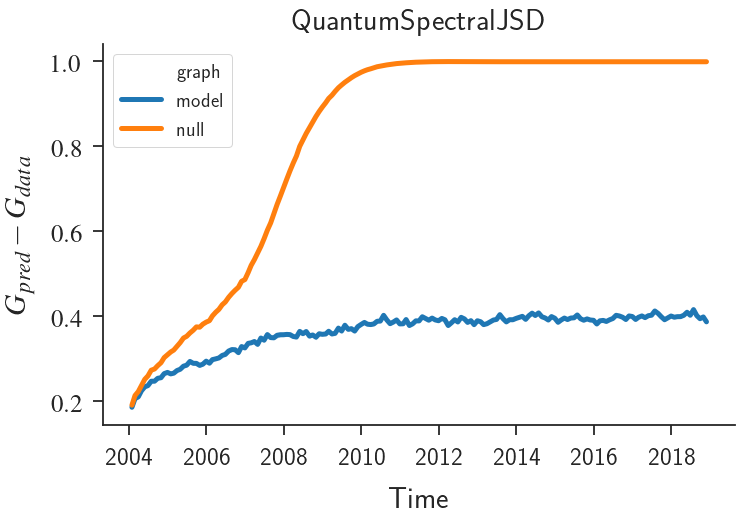

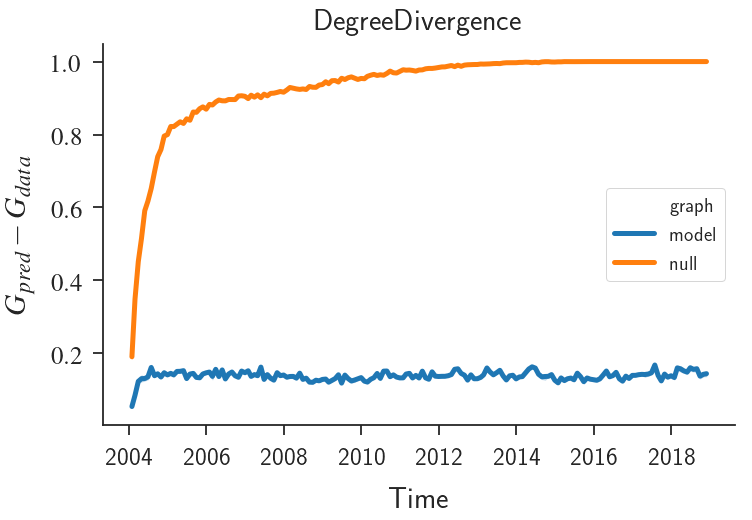

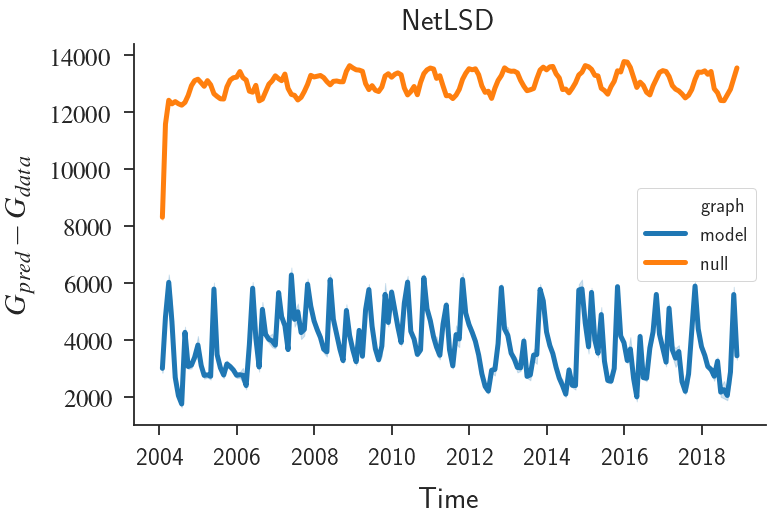

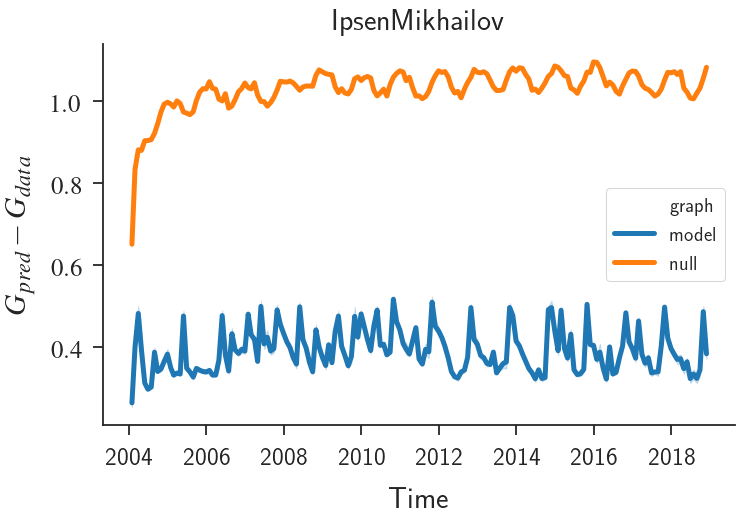

In [130]:
for name,_ in dists.items():
    fig,ax = plt.subplots(figsize=(xs,ys))
    ax = sns.lineplot(x="time", y="dist", hue="graph",
                      data=df_data[df_data.name==name])
    plt.xlabel('Time')
    plt.ylabel("$G_{pred}-G_{data}$")
    plt.title(f"{name}")
    plt.legend()
    custom_frame(ax)
    plt.savefig(f'../figures/dist_{name}.pdf',transparent=True)
    plt.show()

In [39]:
df_growth = get_dist_df(pickle.load(open('../scripts1/results/dist_growth.pickle.dat','rb')))

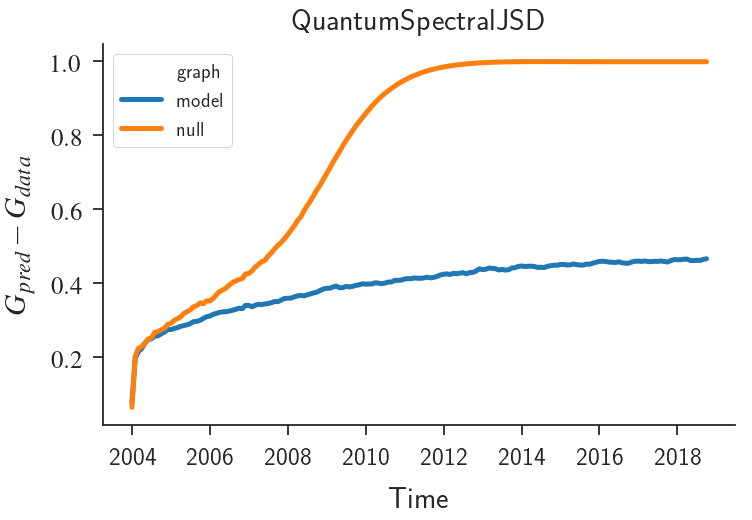

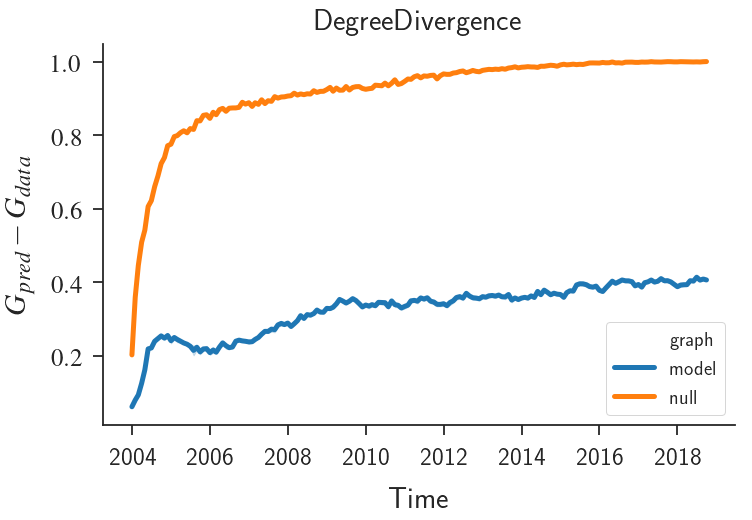

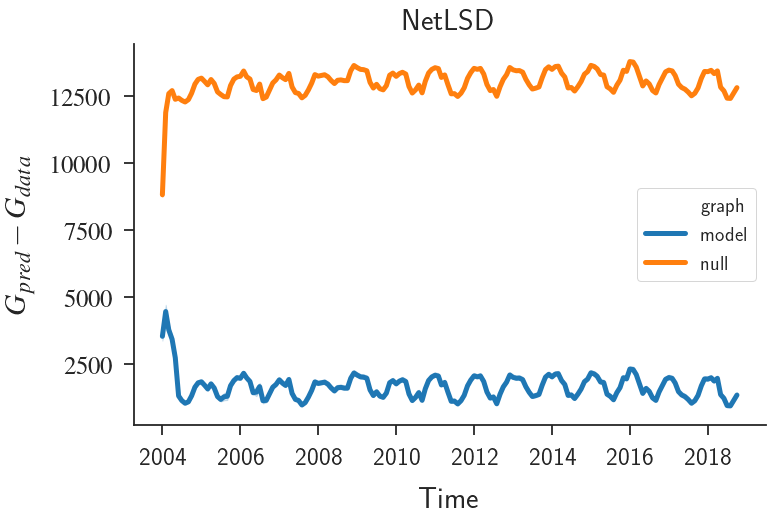

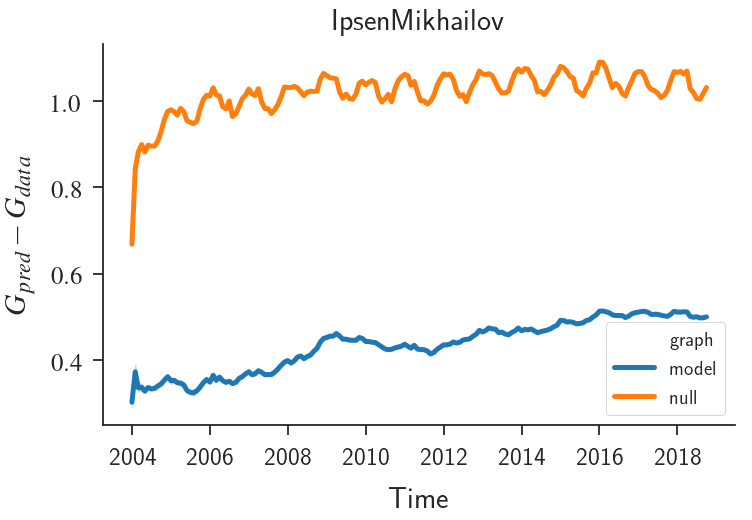

In [40]:
for name,_ in dists.items():
    fig,ax = plt.subplots(figsize=(xs,ys))
    ax = sns.lineplot(x="time", y="dist", hue="graph",
                      data=df_growth[df_growth.name==name])
    plt.xlabel('Time')
    plt.ylabel("$G_{pred}-G_{data}$")
    plt.title(f"{name}")
    plt.legend()
    custom_frame(ax)
    plt.show()

In [129]:
df_decay = get_dist_df(pickle.load(open('../scripts1/results/dist_decay.pickle.dat','rb')))

ValueError: Length of values does not match length of index

In [ ]:
for name,_ in dists.items():
    fig,ax = plt.subplots(figsize=(xs,ys))
    ax = sns.lineplot(x="time", y="dist", hue="graph",
                      data=df_decay[df_decay.name==name])
    plt.xlabel('Time')
    plt.ylabel("$G_{pred}-G_{data}$")
    plt.title(f"{name}")
    plt.legend()
    custom_frame(ax)
    plt.show()

In [43]:
df_stable = get_dist_df(pickle.load(open('../scripts1/results/dist_stable.pickle.dat','rb')))

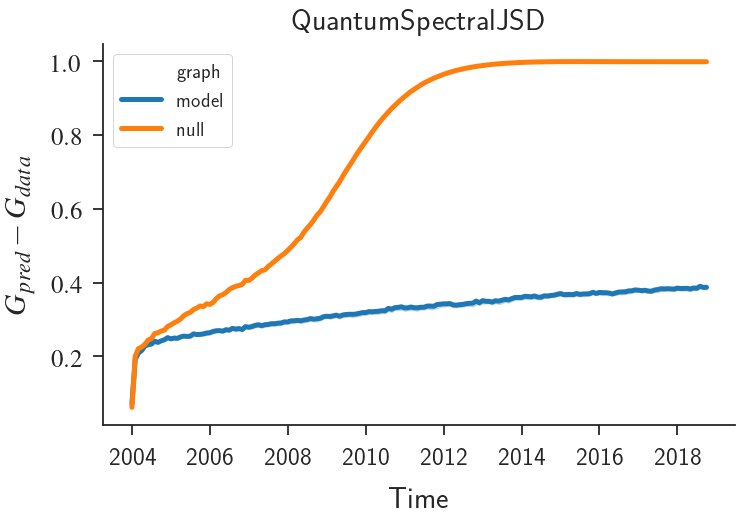

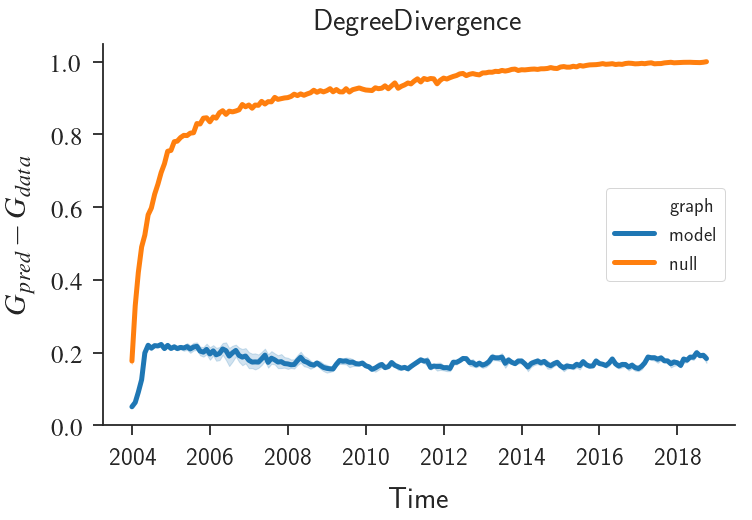

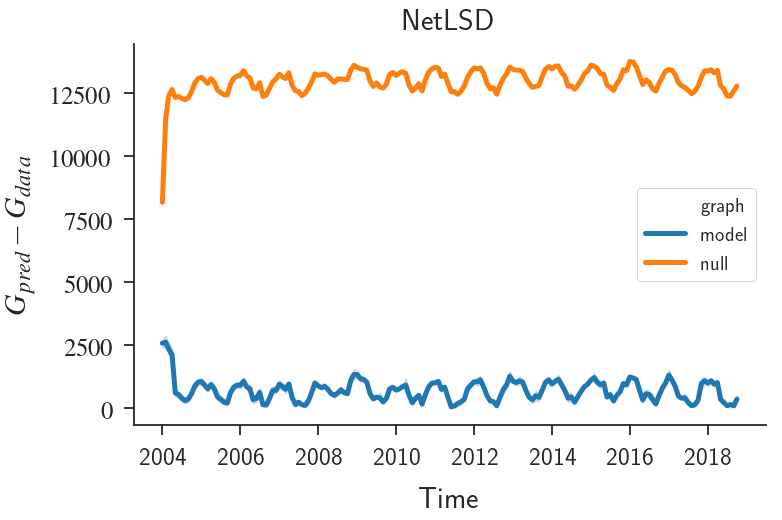

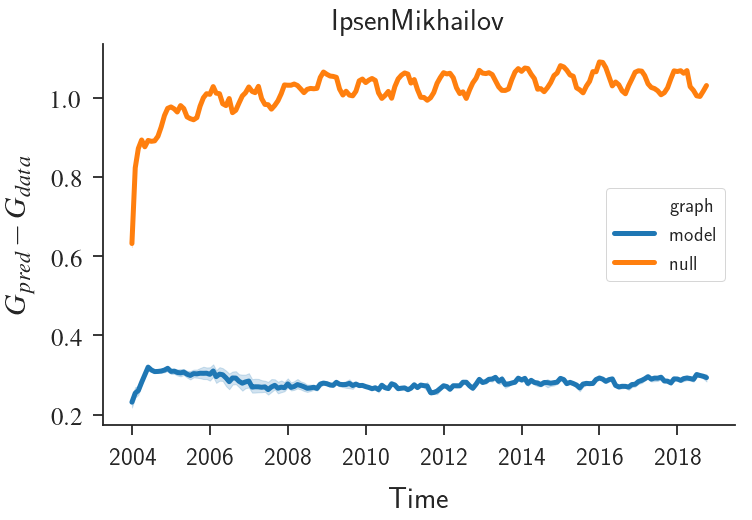

In [44]:
for name,_ in dists.items():
    fig,ax = plt.subplots(figsize=(xs,ys))
    ax = sns.lineplot(x="time", y="dist", hue="graph",
                      data=df_stable[df_stable.name==name])
    plt.xlabel('Time')
    plt.ylabel("$G_{pred}-G_{data}$")
    plt.title(f"{name}")
    plt.legend()
    custom_frame(ax)
    plt.show()

In [45]:
graphs_decay = pickle.load(open('../scripts1/results/graphs_modeled_decay0.pickle.dat','rb'))

In [50]:
Gstart = graphs_decay[0]
Gend = graphs_decay[-1]

In [58]:
# import essential packages
import cartopy.crs as ccrs
import cartopy as cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from cartopy.io import shapereader
from matplotlib.lines import Line2D

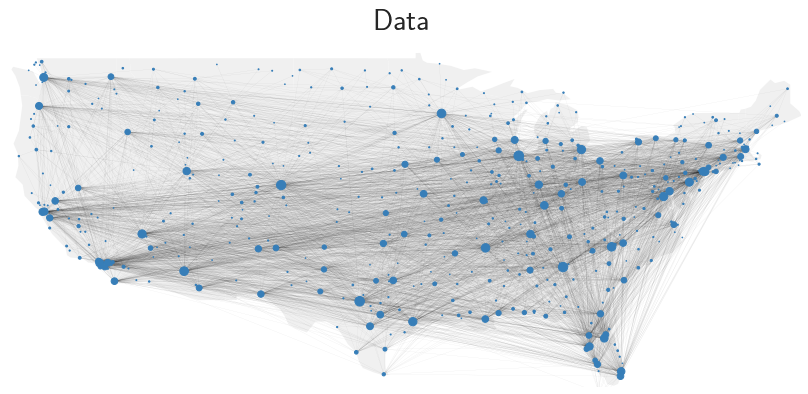

In [77]:
#function to convert node name to readable form
def make_node_name(node):
    node = node.title()
    text = node.split('_')    
    if len(text)<3:
        return ','.join([text[0],text[1].upper()])
    else:
        city = ' '.join(text[0:-1])
        state = text[-1]
        state = state.upper()
        return ','.join([city,state])

#nodes position information
pos = pd.read_pickle('../data/US_air_geo_information.pkl')

#prepare labels for edges
labels = ['Retained Edge', 'Removed Edge'] # this order is fixed
colors = ['black', 'red']
styles = ['solid', 'dashed']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle= s) for c,s in zip(colors,styles)]

#select snapshot for displaying 
year = date(2014,1,1)
G = graphs_air[-1]
G.remove_nodes_from(['payson_az','hanapepe_hi'])

#edges separation
## the edges that are in mainland us
edges_in_land = [edge for edge in G.edges() if (pos[edge[0]].lng >= -128 and pos[edge[0]].lng <= -65 and pos[edge[1]].lng >= -128 and pos[edge[1]].lng <=-65)]
edges_in_land = [edge for edge in edges_in_land if (pos[edge[0]].lat >= 23 and pos[edge[1]].lat >= 23)]


#plot
border = [-125,-67,25,50] # xmin_xmax_ymin_ymax
# sizey = 8
# sizex = sizey * (border[1]-border[0])/(border[3]-border[2])
sizex = stdfigsize(ratio=-1)[0]
sizey = sizex*(border[3]-border[2])/(border[1]-border[0])
fig = plt.figure(figsize=(xs,ys))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)

shp = shapereader.Reader(states_shp)
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
for record, state in zip(shp.records(), shp.geometries()):
    name = record.attributes['name']
    facecolor = '#f0f0f0'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='none',zorder=-1)
ax.set_extent(border, crs=ccrs.PlateCarree())

#draw edges
nx.draw(G,
        pos = pos,
        width= 0.1,
        alpha= 0.2,
        node_size = 0,
        edgelist= edges_in_land,
        edge_color = 'black',
        style = 'solid')

#draw nodes
nx.draw(G,
        pos = pos,
        node_color = '#377eb8',
        width= 0,
        alpha= 1,
        node_size = np.array(list(dict(G.degree()).values()))/2)

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
plt.title('Data')
plt.tight_layout()
#plt.savefig('../figures/Fig.1_US_Domestic_Flights_Network_v2.png',bbox_inches='tight',dpi=500,transparent=True)
plt.show()

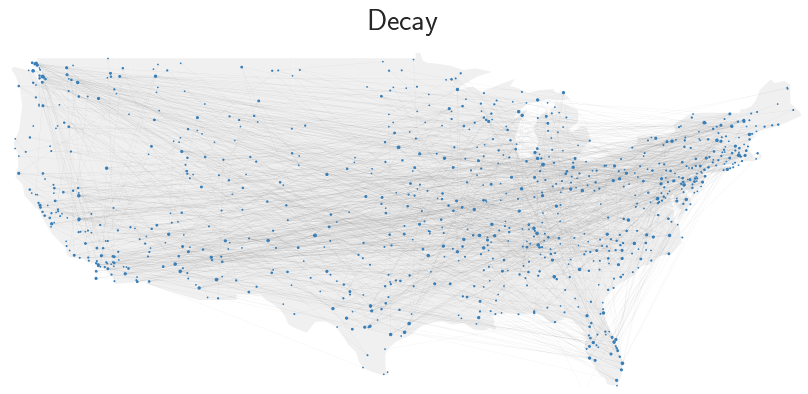

In [75]:
#function to convert node name to readable form
def make_node_name(node):
    node = node.title()
    text = node.split('_')    
    if len(text)<3:
        return ','.join([text[0],text[1].upper()])
    else:
        city = ' '.join(text[0:-1])
        state = text[-1]
        state = state.upper()
        return ','.join([city,state])

#nodes position information
pos = pd.read_pickle('../data/US_air_geo_information.pkl')

#prepare labels for edges
labels = ['Retained Edge', 'Removed Edge'] # this order is fixed
colors = ['black', 'red']
styles = ['solid', 'dashed']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle= s) for c,s in zip(colors,styles)]

#select snapshot for displaying 
year = date(2014,1,1)
G = Gend
G.remove_nodes_from(['payson_az','hanapepe_hi'])

#edges separation
## the edges that are in mainland us
edges_in_land = [edge for edge in G.edges() if (pos[edge[0]].lng >= -128 and pos[edge[0]].lng <= -65 and pos[edge[1]].lng >= -128 and pos[edge[1]].lng <=-65)]
edges_in_land = [edge for edge in edges_in_land if (pos[edge[0]].lat >= 23 and pos[edge[1]].lat >= 23)]


#plot
border = [-125,-67,25,50] # xmin_xmax_ymin_ymax
# sizey = 8
# sizex = sizey * (border[1]-border[0])/(border[3]-border[2])
sizex = stdfigsize(ratio=-1)[0]
sizey = sizex*(border[3]-border[2])/(border[1]-border[0])
fig = plt.figure(figsize=(xs,ys))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)

shp = shapereader.Reader(states_shp)
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
for record, state in zip(shp.records(), shp.geometries()):
    name = record.attributes['name']
    facecolor = '#f0f0f0'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='none',zorder=-1)
ax.set_extent(border, crs=ccrs.PlateCarree())

#draw edges
nx.draw(G,
        pos = pos,
        width= 0.1,
        alpha= 0.2,
        node_size = 0,
        edgelist= edges_in_land,
        edge_color = 'black',
        style = 'solid')

#draw nodes
nx.draw(G,
        pos = pos,
        node_color = '#377eb8',
        width= 0,
        alpha= 1,
        node_size = np.array(list(dict(G.degree()).values()))/2)

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
plt.title('Decay')
plt.tight_layout()
#plt.savefig('../figures/Fig.1_US_Domestic_Flights_Network_v2.png',bbox_inches='tight',dpi=500,transparent=True)
plt.show()

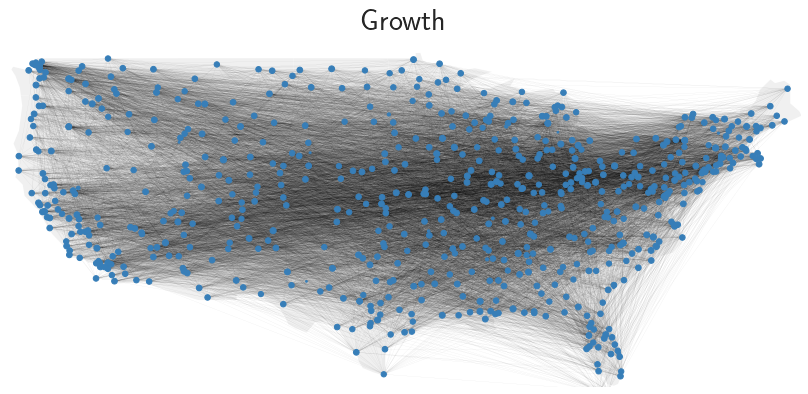

In [73]:
#function to convert node name to readable form
def make_node_name(node):
    node = node.title()
    text = node.split('_')    
    if len(text)<3:
        return ','.join([text[0],text[1].upper()])
    else:
        city = ' '.join(text[0:-1])
        state = text[-1]
        state = state.upper()
        return ','.join([city,state])

#nodes position information
pos = pd.read_pickle('../data/US_air_geo_information.pkl')

#prepare labels for edges
labels = ['Retained Edge', 'Removed Edge'] # this order is fixed
colors = ['black', 'red']
styles = ['solid', 'dashed']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle= s) for c,s in zip(colors,styles)]

#select snapshot for displaying 
year = date(2014,1,1)
G = pickle.load(open('../scripts1/results/graphs_modeled_growth0.pickle.dat','rb'))[-1]
G.remove_nodes_from(['payson_az','hanapepe_hi'])

#edges separation
## the edges that are in mainland us
edges_in_land = [edge for edge in G.edges() if (pos[edge[0]].lng >= -128 and pos[edge[0]].lng <= -65 and pos[edge[1]].lng >= -128 and pos[edge[1]].lng <=-65)]
edges_in_land = [edge for edge in edges_in_land if (pos[edge[0]].lat >= 23 and pos[edge[1]].lat >= 23)]


#plot
border = [-125,-67,25,50] # xmin_xmax_ymin_ymax
# sizey = 8
# sizex = sizey * (border[1]-border[0])/(border[3]-border[2])
sizex = stdfigsize(ratio=-1)[0]
sizey = sizex*(border[3]-border[2])/(border[1]-border[0])
fig = plt.figure(figsize=(xs,ys))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)

shp = shapereader.Reader(states_shp)
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
for record, state in zip(shp.records(), shp.geometries()):
    name = record.attributes['name']
    facecolor = '#f0f0f0'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='none',zorder=-1)
ax.set_extent(border, crs=ccrs.PlateCarree())

#draw edges
nx.draw(G,
        pos = pos,
        width= 0.1,
        alpha= 0.2,
        node_size = 0,
        edgelist= edges_in_land,
        edge_color = 'black',
        style = 'solid')

#draw nodes
nx.draw(G,
        pos = pos,
        node_color = '#377eb8',
        width= 0,
        alpha= 1,
        node_size = np.array(list(dict(G.degree()).values()))/2)

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
plt.title('Growth')
plt.tight_layout()
#plt.savefig('../figures/Fig.1_US_Domestic_Flights_Network_v2.png',bbox_inches='tight',dpi=500,transparent=True)
plt.show()

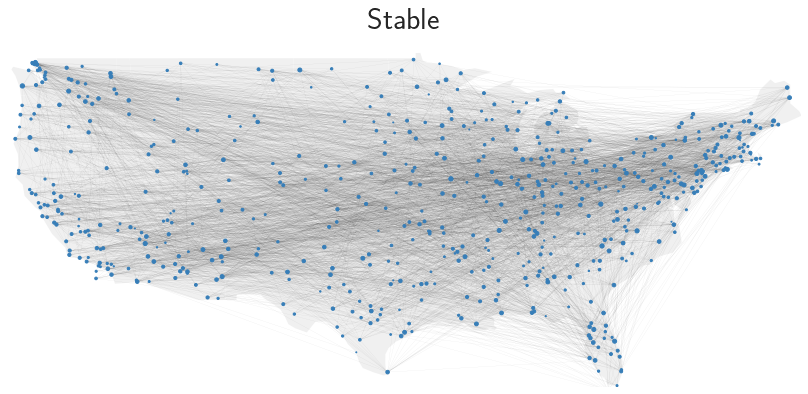

In [72]:
#function to convert node name to readable form
def make_node_name(node):
    node = node.title()
    text = node.split('_')    
    if len(text)<3:
        return ','.join([text[0],text[1].upper()])
    else:
        city = ' '.join(text[0:-1])
        state = text[-1]
        state = state.upper()
        return ','.join([city,state])

#nodes position information
pos = pd.read_pickle('../data/US_air_geo_information.pkl')

#prepare labels for edges
labels = ['Retained Edge', 'Removed Edge'] # this order is fixed
colors = ['black', 'red']
styles = ['solid', 'dashed']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle= s) for c,s in zip(colors,styles)]

#select snapshot for displaying 
year = date(2014,1,1)
G = pickle.load(open('../scripts1/results/graphs_modeled_stable0.pickle.dat','rb'))[-1]
G.remove_nodes_from(['payson_az','hanapepe_hi'])

#edges separation
## the edges that are in mainland us
edges_in_land = [edge for edge in G.edges() if (pos[edge[0]].lng >= -128 and pos[edge[0]].lng <= -65 and pos[edge[1]].lng >= -128 and pos[edge[1]].lng <=-65)]
edges_in_land = [edge for edge in edges_in_land if (pos[edge[0]].lat >= 23 and pos[edge[1]].lat >= 23)]


#plot
border = [-125,-67,25,50] # xmin_xmax_ymin_ymax
# sizey = 8
# sizex = sizey * (border[1]-border[0])/(border[3]-border[2])
sizex = stdfigsize(ratio=-1)[0]
sizey = sizex*(border[3]-border[2])/(border[1]-border[0])
fig = plt.figure(figsize=(xs,ys))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)

shp = shapereader.Reader(states_shp)
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
for record, state in zip(shp.records(), shp.geometries()):
    name = record.attributes['name']
    facecolor = '#f0f0f0'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='none',zorder=-1)
ax.set_extent(border, crs=ccrs.PlateCarree())

#draw edges
nx.draw(G,
        pos = pos,
        width= 0.1,
        alpha= 0.2,
        node_size = 0,
        edgelist= edges_in_land,
        edge_color = 'black',
        style = 'solid')

#draw nodes
nx.draw(G,
        pos = pos,
        node_color = '#377eb8',
        width= 0,
        alpha= 1,
        node_size = np.array(list(dict(G.degree()).values()))/2)

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
plt.title('Stable')
plt.tight_layout()
#plt.savefig('../figures/Fig.1_US_Domestic_Flights_Network_v2.png',bbox_inches='tight',dpi=500,transparent=True)
plt.show()